In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations

In [27]:
path = '../datasets/ground_truth/Train/'
edge_file = 'P28_8_5_delaunay_orig_forGraphSAGE_edges.csv'
node_file =  'P28_8_5_delaunay_orig_forGraphSAGE_nodes.csv'

df_edges = pd.read_csv(os.path.join(path, edge_file))
df_nodes = pd.read_csv(os.path.join(path, node_file))

In [28]:
df_nodes["gt"].replace({'inflammatory': 0, 'lymphocyte': 1, 'fibroblast and endothelial': 2, 'epithelial': 3}, inplace=True) 
# Drop lym, fib, epi, inf columns
df_nodes.drop(['lym', 'fib', 'epi', 'inf'], axis=1, inplace=True)

In [29]:
df_edges

source  target  type    distance  Delta_Entropy  Sorenson_Similarity
0           0       2     0   76.550637       0.000000             0.400000
1           0       4     0  164.769536       0.000000             0.285714
2           4       2     0  148.313856       0.000000             0.333333
3           2       3     0   38.327536       0.000000             0.500000
4           4       3     0  151.267974       0.000000             0.333333
...       ...     ...   ...         ...            ...                  ...
10822     829    3624     0   14.866069       0.027275             0.533333
10823    1702    3624     0   10.770330       0.581793             0.400000
10824     832    3624     0   22.203603       0.389048             0.444444
10825    3624    1703     0   26.000000       0.238693             0.444444
10826    3624    1339     0   15.231546       0.042475             0.333333

[10827 rows x 6 columns]

In [30]:
df_nodes.describe()

id            x            y           gt  Cell_density   
count  3625.000000  3625.000000  3625.000000  3625.000000   3625.000000  \
mean   1812.000000   978.873379   884.271448     1.879724     28.919992   
std    1046.591691   357.363848   542.150938     0.951582     18.049726   
min       0.000000     5.000000     4.000000     0.000000      7.925536   
25%     906.000000   822.000000   432.000000     1.000000     18.544703   
50%    1812.000000  1005.000000   792.000000     2.000000     23.172882   
75%    2718.000000  1190.000000  1304.000000     3.000000     31.651000   
max    3624.000000  1811.000000  1996.000000     3.000000    165.075231   

       Node_Entropy  
count   3625.000000  
mean       0.557159  
std        0.353397  
min        0.000000  
25%        0.376770  
50%        0.598270  
75%        0.859967  
max        1.351784

In [31]:
a = tuple((1,2,3))
b = frozenset((1,2,3))
c = set((1,2,3))
d = list((1,2,3))
a, b, set((2,1)).issubset(c), d

((1, 2, 3), frozenset({1, 2, 3}), True, [1, 2, 3])

In [32]:
a = frozenset((1,2,3))
b = frozenset((2,3,1))
c = frozenset((3,1,2))
d = frozenset((3,2,1))
e = frozenset((2,1,3))
f = frozenset((1,3,2))
g = frozenset((1,3,7))
h = frozenset((1,5,2))

# add a,b,c,d,e,f 
sets = [a,b,c,d,e,f, g, h]
set(sets)

{frozenset({1, 2, 3}), frozenset({1, 3, 7}), frozenset({1, 2, 5})}

In [33]:
np.random.rand()

0.253058426052594

In [34]:
def find_triangles_by_edge(nodes_df, edges_df, SKIP=True):
    # Create a NetworkX graph from the nodes and edges DataFrames
    G = nx.Graph()
    G.add_nodes_from(nodes_df['id'])
    G.add_edges_from(edges_df[['source', 'target']].values)

    # Find triangles
    triangles = set()
    triangles_dict = dict()
    for (u,v) in G.edges:
        tmp = set()
        neighbors_u = set(G.neighbors(u))
        neighbors_v = set(G.neighbors(v))

        vertices = sorted(neighbors_u.intersection(neighbors_v))
        if len(vertices) == 0:
            print('isolated edge: ', u, v)
        elif len(vertices) >3:
            print('more than 3 neighbors: ', u, v, vertices)

            

        if len(vertices) == 1: 
            #if SKIP:
                # Drop edge u,v
                #edges_df = edges_df.drop(edges_df[(edges_df['source'] == u) & (edges_df['target'] == v)].index, inplace=True)
                #edges_df = edges_df.drop(edges_df[(edges_df['source'] == v) & (edges_df['target'] == u)].index, inplace=True)
                #continue
            #triangles_dict[frozenset((u,v))] = 
            t1 = frozenset((u,v,vertices[0]))
            tmp.add(t1)
            triangles.add(t1)
            # MAYBE WE CAN DEAL WITH PADDING LATER IN THE CODE
            #PADDING: add random vertex = u,v or z    
            rand = np.random.rand()
            if rand < .5:
                tmp.add((u,v,u))
                z=u
            else:
                tmp.add((u,v,v)) # we cannot use frozenset with 2 equal nodes
                z=v
            #else: tmp.add(frozenset(u,v,vertices[0]))

            triangles_dict[frozenset((u,v))] = [vertices[0], z]
            print("------ Adding padding -------")

        elif len(vertices) == 2:
            t1, t2 = frozenset((u,v,vertices[0])), frozenset((u,v,vertices[1]))
            tmp.add(t1)
            tmp.add(t2)
            triangles.add(t1)
            triangles.add(t2)

            triangles_dict[frozenset((u,v))] = vertices

        elif len(vertices) == 3:
            t1, t2, t3 = frozenset((u,v,vertices[0])), frozenset((u,v,vertices[1])), frozenset((u,v,vertices[2]))
            tmp.add(t1)
            tmp.add(t2)
            tmp.add(t3)

            for n in vertices:
                if G.degree(n) == 3:
                    print("------ Removing outer triangles -------")
                    try: 
                        tmp.remove(frozenset(G.neighbors(n)))
                        vertices.remove(n)
                    except:
                        print("------No Outer Triangle for: ", list(G.neighbors(n)), " ----------")

            triangles.add(list(tmp)[0])
            triangles.add(list(tmp)[1])

            triangles_dict[frozenset((u,v))] = vertices

    
    return triangles, triangles_dict

In [35]:
triangles, triangles_dict = find_triangles_by_edge(df_nodes, df_edges)


------ Adding padding -------
------ Adding padding -------
------ Adding padding -------
------ Adding padding -------
------ Adding padding -------
------ Adding padding -------
------ Adding padding -------
------ Adding padding -------
------ Removing outer triangles -------
------ Removing outer triangles -------
------ Removing outer triangles -------
------ Adding padding -------
------ Adding padding -------
------ Adding padding -------
------ Removing outer triangles -------
------ Removing outer triangles -------
------ Removing outer triangles -------
------ Adding padding -------
------ Adding padding -------
------ Removing outer triangles -------
------ Removing outer triangles -------
------ Removing outer triangles -------
------ Removing outer triangles -------
------ Removing outer triangles -------
------ Adding padding -------
------ Adding padding -------
------ Adding padding -------
------ Adding padding -------
------ Adding padding -------
------ Adding paddin

In [36]:
len(triangles), len(triangles_dict)

(7203, 10827)

In [37]:
triangles_dict

{frozenset({0, 2}): [4, 3552],
 frozenset({0, 4}): [2, 5],
 frozenset({0, 5}): [4, 6],
 frozenset({0, 6}): [1, 5],
 frozenset({0, 1}): [6, 3552],
 frozenset({0, 3552}): [1, 2],
 frozenset({1, 6}): [0, 1221],
 frozenset({1, 1221}): [6, 7],
 frozenset({1, 7}): [1221, 3552],
 frozenset({1, 3552}): [0, 7],
 frozenset({2, 4}): [0, 3],
 frozenset({2, 3}): [4, 3552],
 frozenset({2, 3552}): [0, 3],
 frozenset({3, 4}): [2, 15],
 frozenset({3, 15}): [4, 15],
 frozenset({3, 3552}): [2, 3552],
 frozenset({4, 5}): [0, 16],
 frozenset({4, 15}): [3, 1475],
 frozenset({4, 16}): [5, 1474],
 frozenset({4, 1474}): [16, 1475],
 frozenset({4, 1475}): [15, 1474],
 frozenset({5, 6}): [0, 8],
 frozenset({5, 8}): [6, 14],
 frozenset({5, 14}): [8, 17],
 frozenset({5, 16}): [4, 17],
 frozenset({5, 17}): [14, 16],
 frozenset({6, 8}): [5, 1221],
 frozenset({6, 1221}): [1, 8],
 frozenset({7, 1221}): [1, 1222],
 frozenset({7, 1222}): [1221, 1223],
 frozenset({7, 10}): [1223, 3553],
 frozenset({7, 1223}): [10, 1222],

In [33]:
tri = triangles_dict.get(frozenset((2,1106)))

t1, t2 = tri[0], tri[1]

t1, t2

TypeError: 'NoneType' object is not subscriptable

In [38]:
edges = df_edges[['source', 'target']].values

In [40]:
edges

array([[   0,    2],
       [   0,    4],
       [   4,    2],
       ...,
       [ 832, 3624],
       [3624, 1703],
       [3624, 1339]], dtype=int64)

In [41]:
for u, v in edges:
    t12 = triangles_dict.get(frozenset((u,v)))
    if t12 is None:
        print(u,v, t12)
        break
    print(t12)
    

[4, 3552]
[2, 5]
[0, 3]
[4, 3552]
[2, 15]
[0, 16]
[4, 6]
[0, 8]
[1, 5]
[6, 3552]
[0, 1221]
[6, 14]
[5, 1221]
[13, 1222]
[9, 1224]
[12, 14]
[8, 17]
[5, 9]
[14, 1222]
[8, 13]
[9, 20]
[4, 15]
[3, 1475]
[5, 1474]
[4, 17]
[5, 21]
[14, 16]
[5, 33]
[20, 1224]
[13, 2268]
[14, 19]
[13, 21]
[14, 34]
[17, 20]
[14, 34]
[29, 35]
[27, 46]
[28, 3481]
[16, 34]
[17, 32]
[33, 1473]
[16, 1443]
[21, 2268]
[17, 20]
[21, 33]
[17, 1443]
[35, 1227]
[25, 28]
[31, 44]
[35, 45]
[27, 31]
[26, 28]
[35, 3481]
[27, 1442]
[36, 1227]
[23, 1239]
[24, 1229]
[40, 1227]
[23, 3488]
[25, 1229]
[25, 1442]
[35, 3488]
[28, 50]
[31, 46]
[28, 47]
[29, 45]
[28, 665]
[45, 663]
[46, 61]
[45, 1227]
[31, 52]
[52, 1226]
[50, 60]
[45, 49]
[50, 61]
[57, 58]
[52, 1252]
[54, 61]
[54, 59]
[52, 1246]
[52, 1244]
[58, 1241]
[49, 1241]
[48, 52]
[60, 1226]
[49, 56]
[60, 48]
[48, 1242]
[52, 1261]
[45, 57]
[47, 52]
[45, 62]
[61, 1535]
[47, 3499]
[70, 140]
[68, 131]
[69, 71]
[68, 73]
[70, 72]
[68, 1421]
[71, 152]
[70, 1421]
[71, 76]
[73, 131]
[70,

In [129]:
t12 = None
if not t12 is None:
    print(2)

In [46]:
# Function to find triangles that returns a set of frozensets, representing the triangles
def find_triangles(nodes_df, edges_df):
    # Create a NetworkX graph from the nodes and edges DataFrames
    G = nx.Graph()
    G.add_nodes_from(nodes_df['id'])
    G.add_edges_from(edges_df[['source', 'target']].values)

    # Find triangles
    triangles = set()
    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        for u, v in combinations(neighbors, 2):
            if G.has_edge(u, v):
                #if node == 17:
                #    print(list(G.neighbors(node)))
                #    print(list(G.neighbors(u)), list(G.neighbors(v)))
                #    print(node,u,v)
                # Use frozenset to ensure that triangles with the same nodes are considered equal
                triangles.add(frozenset([node, u, v]))
        
    triangles = remove_outer_triangles(G, triangles)

    return triangles

def remove_outer_triangles(G, triangles):
    print("------ Removing outer triangles -------")
    for node in G.nodes:
        if G.degree(node)==3:
            try:
                triangles.remove(frozenset(G.neighbors(node)))
            except:
                print("------No Outer Triangle for: ", list(G.neighbors(node)), " ----------")
    
    return triangles
            
    

In [87]:
t1 = [frozenset((1,2,3)),frozenset((1,2,4))]
t3 = set([frozenset((1,2,3)),frozenset((1,2,4))])
t2 = set([frozenset((1,2,3)),frozenset((1,2,4))])

tri = set()

tri.add(frozenset((1,2,3)))

tri.add(((1,2,2)))

tri.add(frozenset((2,1,3)))

list(tri)

[frozenset({1, 2, 3}), (1, 2, 2)]

TypeError: 'int' object is not iterable

In [58]:
tmp.get(frozenset((11,10)))

10

In [69]:
neighbors_u = set(G.neighbors(10))
neighbors_v = set(G.neighbors(12))

vertices = neighbors_u.intersection(neighbors_v)
sorted(vertices)[0]

3

In [47]:
triangles = find_triangles(df_nodes, df_edges)

edge = set((10,12))
for t in triangles:
    if edge.issubset(t):
        print(t)

------ Removing outer triangles -------
------No Outer Triangle for:  [1, 2, 5]  ----------
frozenset({10, 3, 12})
frozenset({10, 11, 12})


In [45]:
triangles

{frozenset({1168, 1659, 1667}),
 frozenset({44, 56, 1758}),
 frozenset({455, 484, 485}),
 frozenset({1438, 1439, 1440}),
 frozenset({1461, 1688, 1690}),
 frozenset({227, 1438, 1440}),
 frozenset({1577, 1578, 1623}),
 frozenset({123, 1344, 1608}),
 frozenset({185, 1416, 1417}),
 frozenset({301, 956, 1750}),
 frozenset({555, 556, 602}),
 frozenset({1479, 1481, 1482}),
 frozenset({1161, 1491, 1804}),
 frozenset({270, 328, 1817}),
 frozenset({516, 557, 559}),
 frozenset({236, 1411, 1700}),
 frozenset({58, 61, 68}),
 frozenset({486, 1130, 1707}),
 frozenset({190, 823, 1677}),
 frozenset({721, 886, 892}),
 frozenset({210, 219, 1146}),
 frozenset({1306, 1307, 1465}),
 frozenset({455, 479, 480}),
 frozenset({587, 590, 593}),
 frozenset({1100, 1111, 1135}),
 frozenset({297, 299, 300}),
 frozenset({1371, 1447, 1528}),
 frozenset({129, 1547, 1548}),
 frozenset({1255, 1587, 1588}),
 frozenset({1080, 1764, 1766}),
 frozenset({52, 53, 798}),
 frozenset({972, 985, 988}),
 frozenset({1122, 1434, 1836}

In [69]:
df_edges[df_edges['target'] == 17]

source  target  type   distance  Delta_Entropy  Sorenson_Similarity
36       11      17     0  72.124892       0.376770             0.333333
37       12      17     0  82.492424       0.000000             0.266667
168      18      17     0  63.285069       0.123632             0.461538

In [71]:
pos = df_nodes[['x', 'y']].values
pos[:,1] = -pos[:,1]

In [72]:
G = nx.Graph()
G.add_nodes_from(df_nodes['id'])
G.add_edges_from(df_edges[['source', 'target']].values)
H = G.subgraph([10,11,12,17,3,100,2,100,1106,18])


# draw graph
#nx.draw(G, pos=pos,  node_size=5, node_color='lightblue', edge_color='grey')

# draw subgraph with nodes 10,11,12,17,3,100,2,100,1106,18
nx.draw(H, pos=pos, node_size=20, node_color='lightblue', edge_color='grey', with_labels=True)


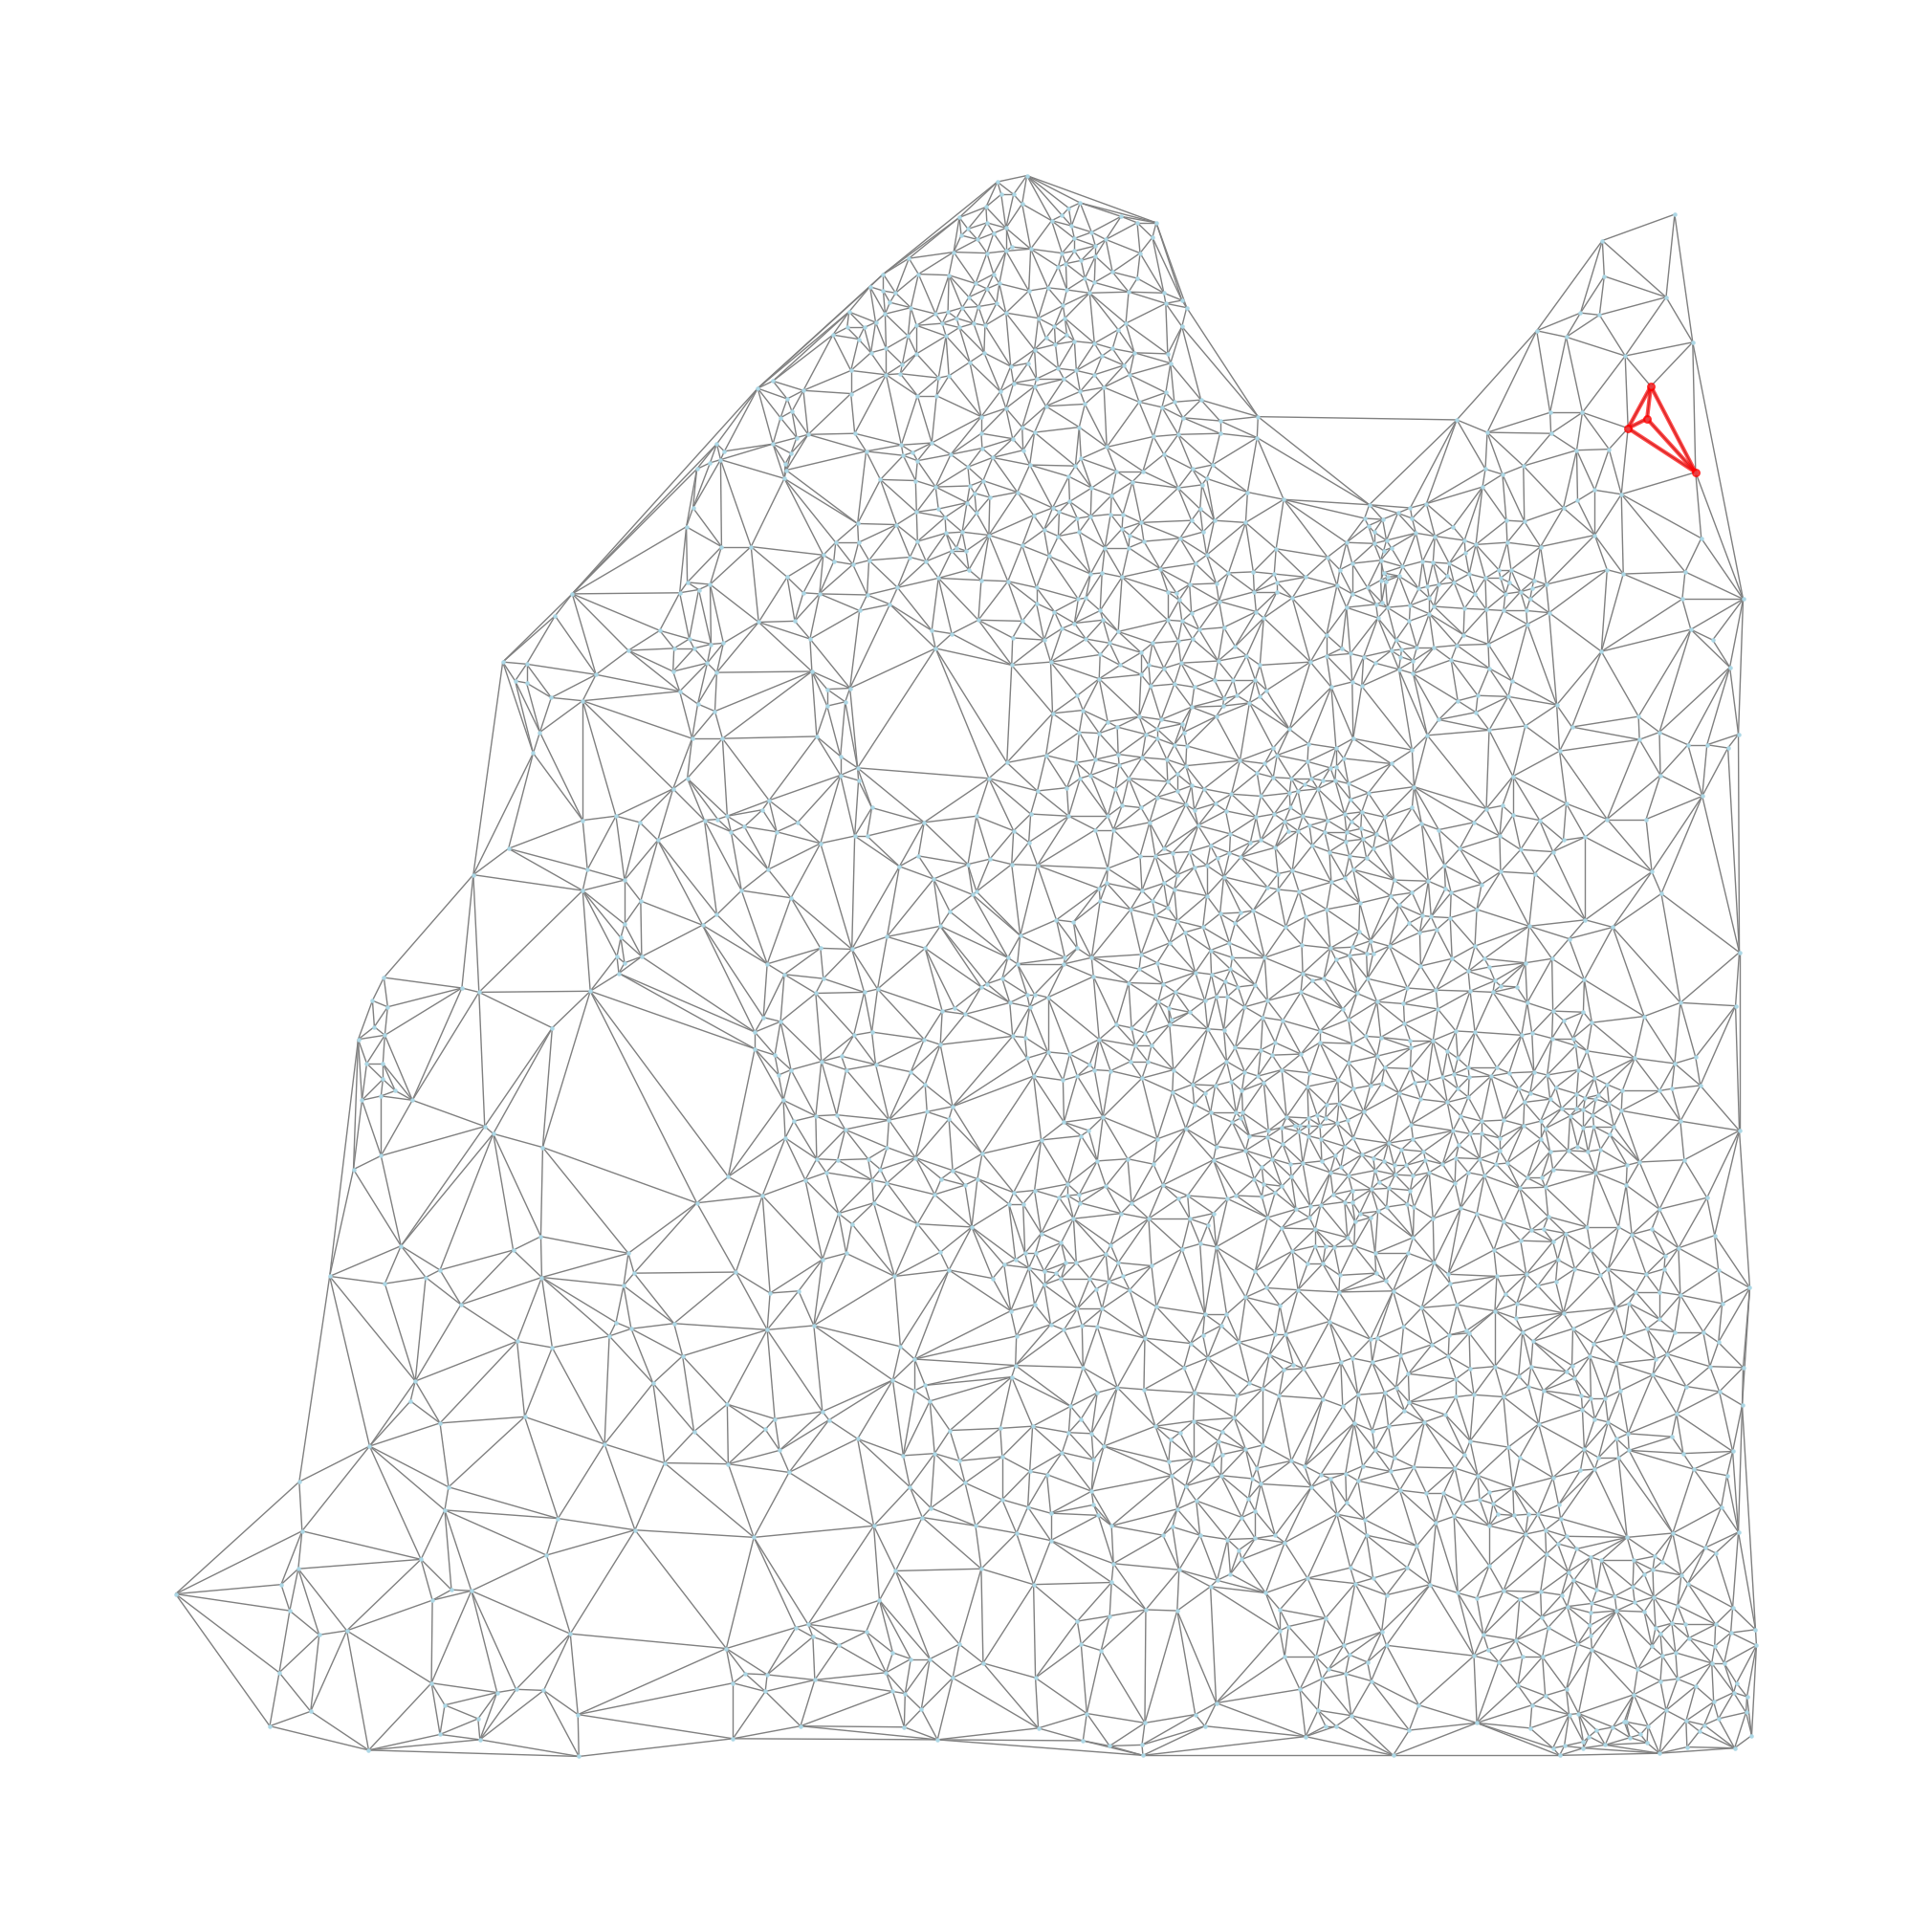

In [74]:
# Draw graph and highlight the subgraph
# figure size
plt.figure(figsize=(20,20))
nx.draw(G, pos=pos,  node_size=5, node_color='lightblue', edge_color='grey')

highlighted_nodes = [10,11,12,17]
highlighted_edges = [(10,11), (10,12), (10,17), (11,12), (11,17), (12,17)]
# then highlight the subgraph by overwriting node colors
nx.draw_networkx_nodes(G, pos, nodelist=highlighted_nodes, node_color='r', alpha=0.7, node_size=30)
nx.draw_networkx_edges(G, pos, edgelist=highlighted_edges, edge_color='r', alpha=0.7, width=3)

plt.show()

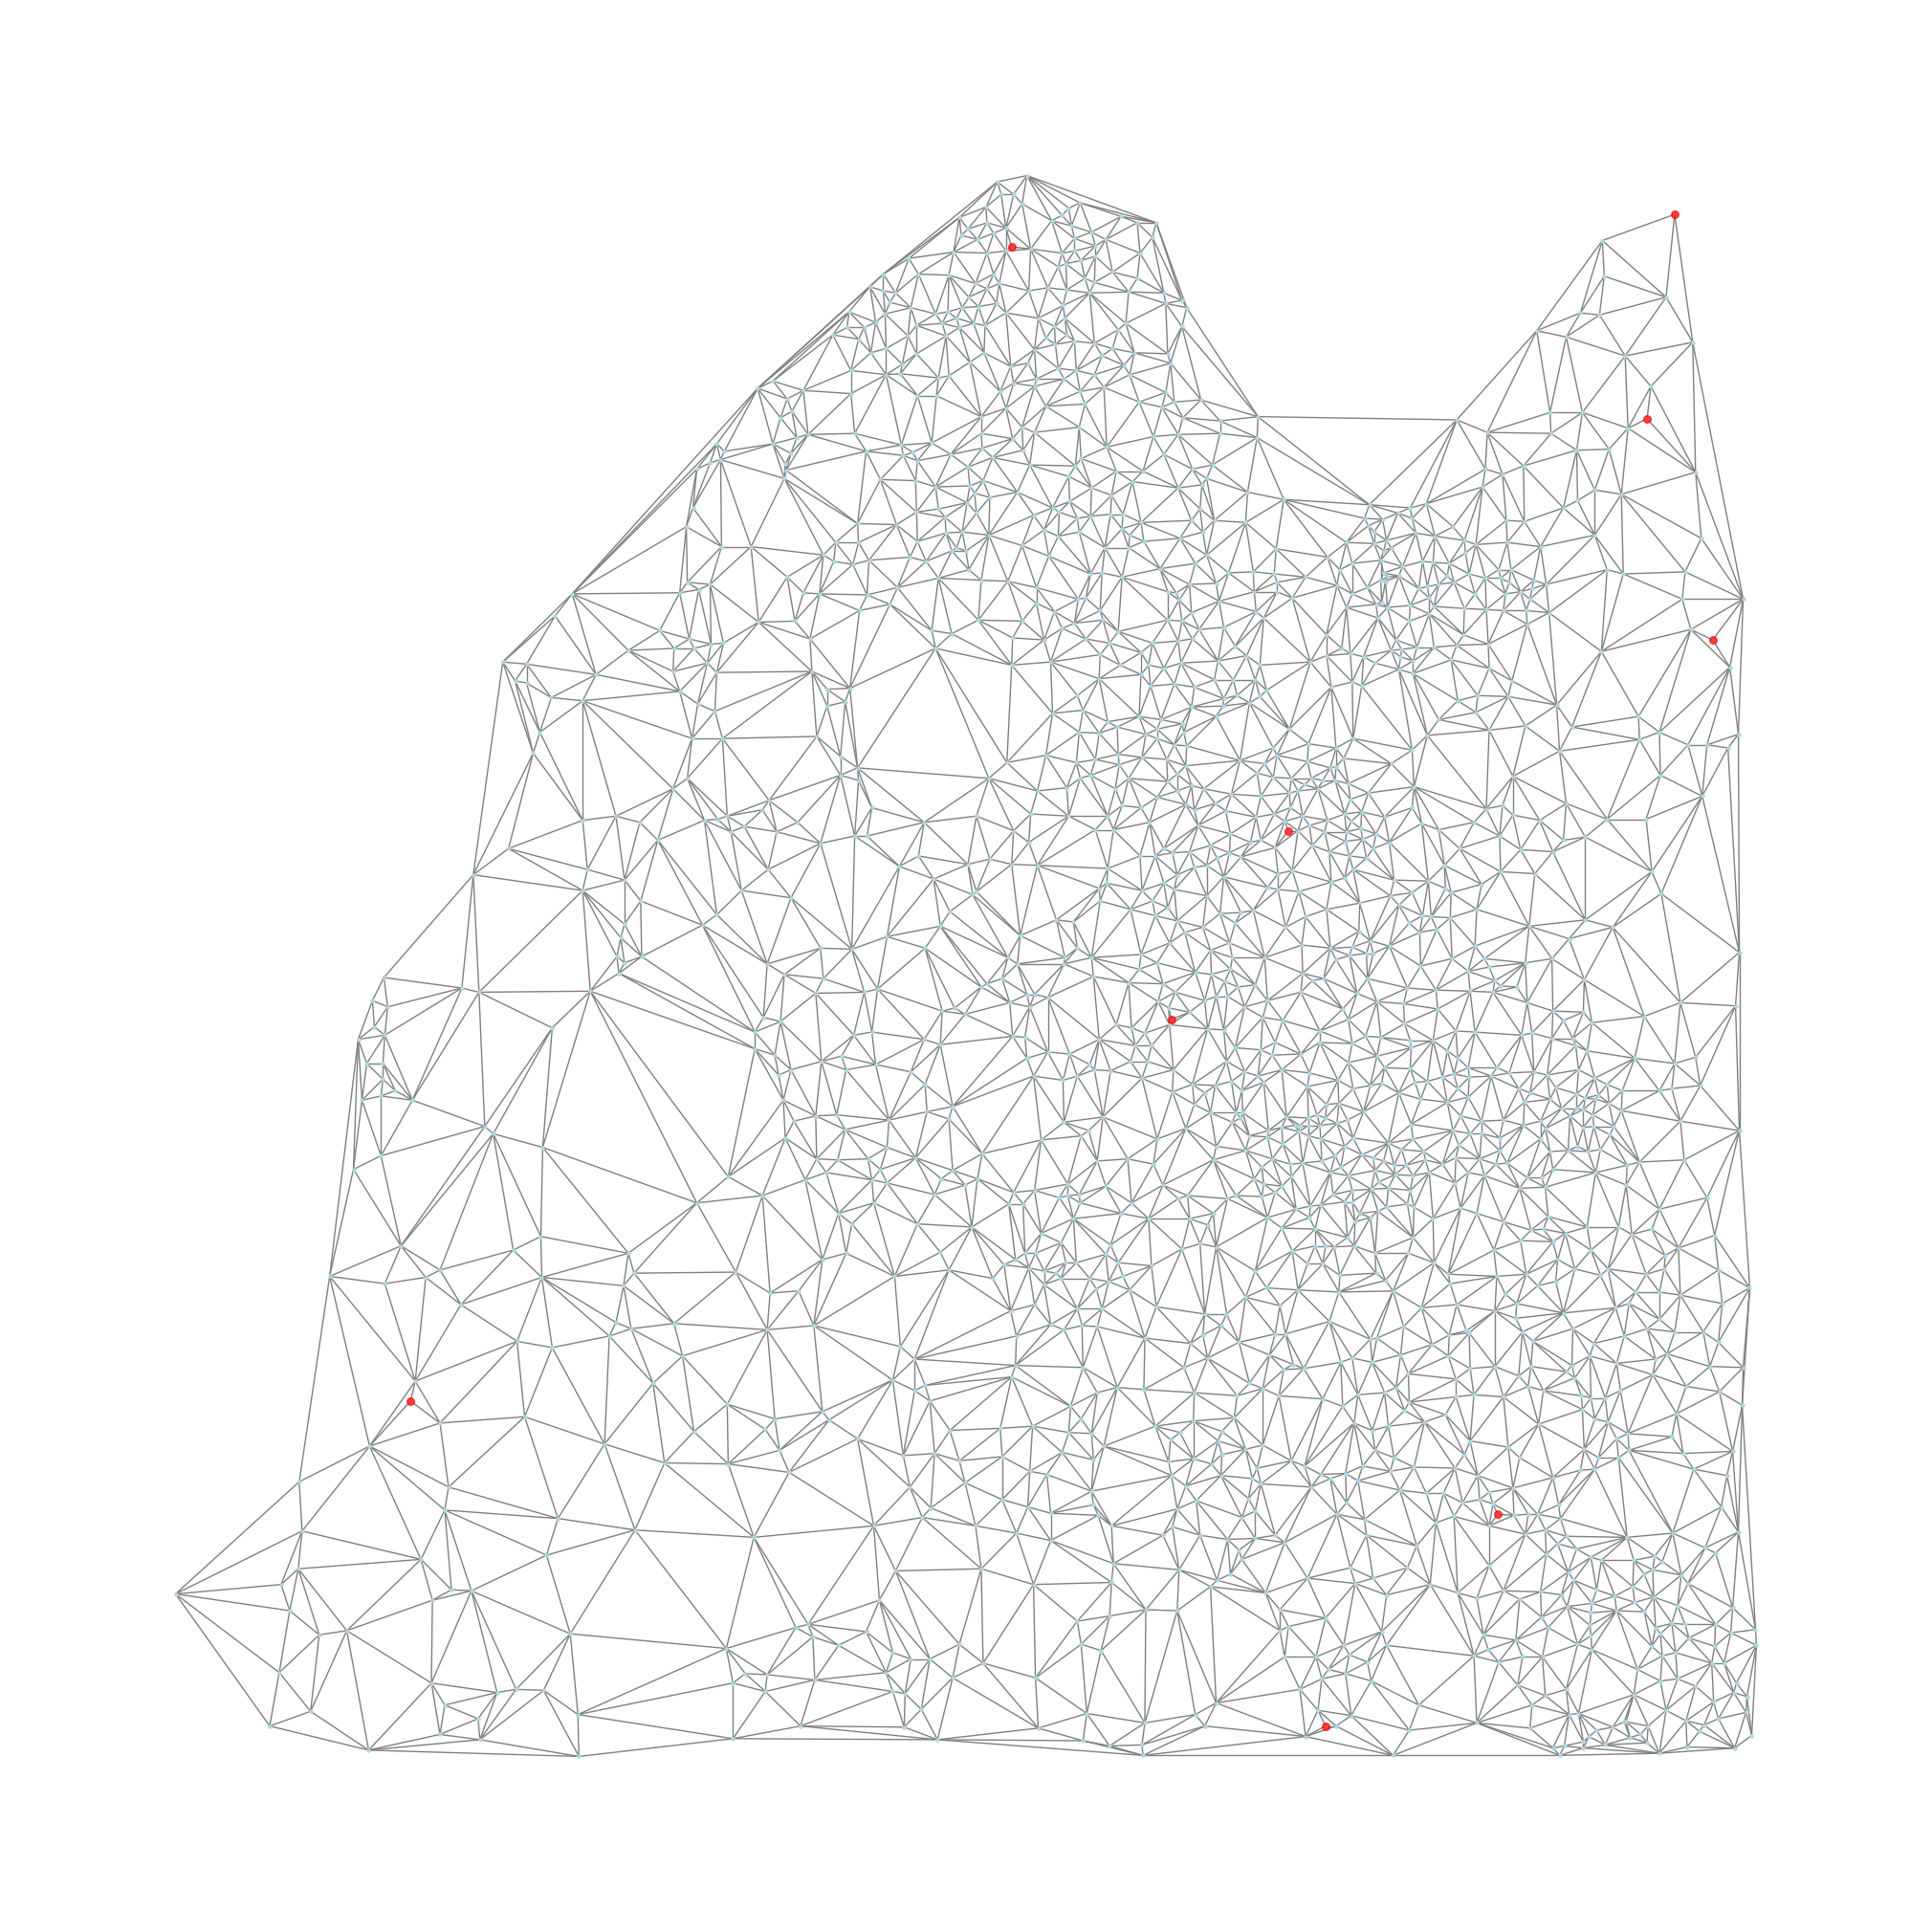

In [76]:
# nodes with degree 3
degree3_nodes = [node for node, degree in G.degree() if degree == 3]

# draw graph and highlight nodes with degree 3
plt.figure(figsize=(20,20))
nx.draw(G, pos=pos,  node_size=5, node_color='lightblue', edge_color='grey')
nx.draw_networkx_nodes(G, pos, nodelist=degree3_nodes, node_color='r', alpha=0.7, node_size=30)
plt.show()


In [8]:
triangles_df = pd.DataFrame(triangles, columns=['node1', 'node2', 'node3'])
triangles_df

node1  node2  node3
0        20     29    969
1       669    736    925
2       727    880    881
3       956   1750   1752
4        89     90     91
...     ...    ...    ...
3651    332    657    874
3652    175   1453   1676
3653    237    238   1087
3654   1020   1720   1724
3655    542    543    559

[3656 rows x 3 columns]

In [49]:
edges = df_edges[['source', 'target']].values
# Convert to set of frozensets
edges = list([set([edge[0], edge[1]]) for edge in edges])
len(edges)

5492

In [50]:
triangles

{frozenset({1168, 1659, 1667}),
 frozenset({44, 56, 1758}),
 frozenset({455, 484, 485}),
 frozenset({1438, 1439, 1440}),
 frozenset({1461, 1688, 1690}),
 frozenset({227, 1438, 1440}),
 frozenset({1577, 1578, 1623}),
 frozenset({123, 1344, 1608}),
 frozenset({185, 1416, 1417}),
 frozenset({301, 956, 1750}),
 frozenset({555, 556, 602}),
 frozenset({1479, 1481, 1482}),
 frozenset({1161, 1491, 1804}),
 frozenset({270, 328, 1817}),
 frozenset({516, 557, 559}),
 frozenset({236, 1411, 1700}),
 frozenset({58, 61, 68}),
 frozenset({486, 1130, 1707}),
 frozenset({190, 823, 1677}),
 frozenset({721, 886, 892}),
 frozenset({210, 219, 1146}),
 frozenset({1306, 1307, 1465}),
 frozenset({455, 479, 480}),
 frozenset({587, 590, 593}),
 frozenset({1100, 1111, 1135}),
 frozenset({297, 299, 300}),
 frozenset({1371, 1447, 1528}),
 frozenset({129, 1547, 1548}),
 frozenset({1255, 1587, 1588}),
 frozenset({1080, 1764, 1766}),
 frozenset({52, 53, 798}),
 frozenset({972, 985, 988}),
 frozenset({1122, 1434, 1836}

In [51]:
t1, t2, t3 = 0,0,0
for e in edges:
    tmp=0

    for t in triangles:
        if e.issubset(t):
            tmp+=1
    t1 +=1 if tmp==1 else 0
    t2 +=1 if tmp==2 else 0
    t3 +=1 if tmp==3 else 0

print("Edges with 1 triangle: ", t1)
print("Edges with 2 triangles: ", t2)
print("Edges with 3 triangles: ", t3)

    
    

Edges with 1 triangle:  40
Edges with 2 triangles:  5452
Edges with 3 triangles:  0


In [96]:

class TriangleAnalyzer:
    def __init__(self, nodes_df, edges_df):
        self.nodes_df = nodes_df
        self.edges_df = edges_df
        self.G = self._build_graph()
        self.triangles = self.find_triangles()

    def _build_graph(self):
        G = nx.Graph()
        G.add_nodes_from(self.nodes_df['id'])
        G.add_edges_from(self.edges_df[['source', 'target']].values)
        return G

    def find_triangles(self):
        triangles = []
        for node in self.G.nodes:
            neighbors = list(self.G.neighbors(node))
            for u, v in combinations(neighbors, 2):
                if self.G.has_edge(u, v):
                    triangles.append(sorted([node, u, v]))
        return [list(x) for x in set(tuple(x) for x in triangles)]

    def count_triangles(self):
        return len(self.triangles)

    def compute_triangle_features(self):
        triangle_features = []

        for triangle in self.triangles:
            node_features = self.nodes_df[self.nodes_df['id'].isin(triangle)] # nodes involved in the triangle

            # Filter edge_features based on the triangle nodes
            edge_mask = self.edges_df.apply(lambda x: (x['source'], x['target']) in combinations(triangle, 2) or (x['target'], x['source']) in combinations(triangle, 2), axis=1)
            edge_features = self.edges_df[edge_mask]

            # Triangle area
            coords = node_features[['x', 'y']].values
            area = 0.5 * abs(np.dot(coords[:, 0], np.roll(coords[:, 1], 1)) - np.dot(coords[:, 1], np.roll(coords[:, 0], 1)))

            # Angle-based features
            angles = []
            for i in range(3):
                a, b, c = coords[i % 3], coords[(i + 1) % 3], coords[(i + 2) % 3]
                ba, bc = a - b, c - b
                cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
                angle = np.arccos(cosine_angle)
                angles.append(angle)

            # Triangle perimeter
            perimeter = edge_features['distance'].sum()

            # Average cell density and entropy
            avg_density = node_features['Cell_density'].mean()
            avg_entropy = node_features['Node_Entropy'].mean()

            # Cell type diversity
                        
            cell_type_diversity = len(node_features['gt'].unique())
           
            # Max/Min/Average edge features
            max_distance = edge_features['distance'].max()
            min_distance = edge_features['distance'].min()
            avg_distance = edge_features['distance'].mean()

            # Standard deviation of edge features
            std_distance = edge_features['distance'].std()

            triangle_features.append({
                'nodes': triangle,
                'area': area,
                'angles': angles,
                'perimeter': perimeter,
                'avg_density': avg_density,
                'avg_entropy': avg_entropy,
                'cell_type_diversity': cell_type_diversity,
                'max_distance': max_distance,
                'min_distance': min_distance,
                'avg_distance': avg_distance,
                'std_distance': std_distance
            })

        return pd.DataFrame(triangle_features)

In [97]:
TA = TriangleAnalyzer(df_nodes, df_edges)
triangle_feat = TA.compute_triangle_features()


KeyboardInterrupt: 

In [82]:
triangle_feat.describe()

area    perimeter  avg_density  avg_entropy   
count   3656.000000  3656.000000  3656.000000  3656.000000  \
mean     521.361871   105.154502    35.262054     0.460359   
std      768.029885    62.614526    16.343398     0.309383   
min       10.000000    17.186929    10.891557     0.000000   
25%      155.000000    64.560687    24.609142     0.136705   
50%      288.500000    88.834882    30.550033     0.548300   
75%      559.000000   123.630778    40.113454     0.672208   
max    13394.000000   558.586784   120.377455     1.237467   

       cell_type_diversity  max_distance  min_distance  avg_distance   
count          3656.000000   3656.000000   3656.000000   3656.000000  \
mean              1.654267     44.349015     23.665180     35.051501   
std               0.656441     27.904625     14.677844     20.871509   
min               1.000000      7.071068      2.000000      5.728976   
25%               1.000000     27.013884     14.317821     21.520229   
50%               2.000000     36.891733     19.761036     29.611627   
75%               2.000000     51.623638     28.288689     41.210259   
max               3.000000    276.479656    157.165518    186.195595   

       std_distance  
count   3656.000000  
mean      10.958659  
std       10.278040  
min        0.111955  
25%        4.953431  
50%        8.122588  
75%       12.938448  
max      108.830368

In [83]:
triangle_feat['cell_type_diversity'].value_counts()

cell_type_diversity
2    1644
1    1638
3     374
Name: count, dtype: int64

In [67]:
cells = [[0,1,0,0], [1,0,0,0], [0,1,0,0]]
cell_types = pd.DataFrame(cells, columns=['lym', 'epi', 'fib', 'inf'])
print(cell_types)
cell_type_diversity = (cell_types.sum(axis=0) > 0).sum()
print(cell_type_diversity)

   lym  epi  fib  inf
0    0    1    0    0
1    1    0    0    0
2    0    1    0    0
2


In [68]:
cell_types

lym  epi  fib  inf
0    0    1    0    0
1    1    0    0    0
2    0    1    0    0

In [12]:

def compute_triangle_features(nodes_df, edges_df):
    G = nx.Graph()
    
    # Add nodes and their attributes to the graph
    for _, row in nodes_df.iterrows():
        G.add_node(int(row['id']), **row.to_dict())

    # Add edges and their attributes to the graph
    for _, row in edges_df.iterrows():
        G.add_edge(int(row['source']), int(row['target']), **row.to_dict())

    # Compute triangles
    triangles = [sorted(triangle) for triangle in nx.enumerate_all_cliques(G) if len(triangle) == 3]

    triangle_features = []
    
    for triangle in triangles:
        # Retrieve node features
        node_features = nodes_df[nodes_df['id'].isin(triangle)].set_index('id')

        # Retrieve edge features
        edge_features = []
        for i, j in combinations(triangle, 2):
            edge_features.append(G[i][j])
        edge_features_df = pd.DataFrame(edge_features)

        coords = node_features.loc[triangle, ['x', 'y']].values
        area = 0.5 * abs(np.dot(coords[:, 0], np.roll(coords[:, 1], 1)) - np.dot(coords[:, 1], np.roll(coords[:, 0], 1)))

        # Angle-based features
        angles = []
        for i in range(3):
            a, b, c = coords[i % 3], coords[(i + 1) % 3], coords[(i + 2) % 3]
            ba, bc = a - b, c - b
            cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc)) if (np.linalg.norm(ba) * np.linalg.norm(bc)) != 0 else 'NaN'
            angle = np.arccos(cosine_angle) if cosine_angle != 'NaN' else 0
            # The following can be nan=>0
            angles.append(angle if angle is not np.nan else 0)

        # Triangle perimeter
        perimeter = edge_features_df['distance'].sum()

        # Average cell density and entropy
        avg_density = node_features['Cell_density'].mean()
        avg_entropy = node_features['Node_Entropy'].mean()

        # Cell type diversity
        cell_type_diversity = len(node_features['gt'].unique())

        # Crossing edges
        crossing_edges = edge_features_df['type'].sum()

        # Max/Min/Average edge features
        max_distance = edge_features_df['distance'].max()
        min_distance = edge_features_df['distance'].min()
        avg_distance = edge_features_df['distance'].mean()

        # Standard deviation of edge features
        std_distance = edge_features_df['distance'].std()

        # Entropy/density dispersion
        #entropy_dispersion = node_features['Node_Entropy'].std() / node_features['Node_Entropy'].mean()
        density_dispersion = node_features['Cell_density'].std() / node_features['Cell_density'].mean()

        # Triangle inequality ratio
        side_lengths = edge_features_df['distance'].values
        longest_side = side_lengths.max()
        # The following can be nan=>0
        triangle_inequality_ratio = longest_side / (side_lengths.sum() - longest_side) if side_lengths.sum() - longest_side > 0 else 0

        # Aspect Ratio
        shortest_side = side_lengths.min()
        # The following can be nan=>0
        aspect_ratio = longest_side / shortest_side if shortest_side > 0 else 0


        triangle_features.append({
            'nodes': triangle,
            'cross_edges': crossing_edges, 
            'area': area,
            'angles': angles,
            'perimeter': perimeter,
            'avg_density': avg_density,
            'avg_entropy': avg_entropy,
            'cell_type_diversity': cell_type_diversity,
            'max_distance': max_distance,
            'min_distance': min_distance,
            'avg_distance': avg_distance,
            'std_distance': std_distance,
         #   'entropy_dispersion': entropy_dispersion,
            'density_dispersion': density_dispersion,
            'triangle_inequality_ratio': triangle_inequality_ratio,
            'aspect_ratio': aspect_ratio
        })

    return pd.DataFrame(triangle_features)


In [13]:
triangle_feat = compute_triangle_features(df_nodes, df_edges)

In [14]:
triangle_feat.describe()

cross_edges          area    perimeter  avg_density  avg_entropy   
count  3656.000000   3656.000000  3656.000000  3656.000000  3656.000000  \
mean      0.045131    521.361871   105.154502    35.262054     0.460359   
std       0.296608    768.029885    62.614526    16.343398     0.309383   
min       0.000000     10.000000    17.186929    10.891557     0.000000   
25%       0.000000    155.000000    64.560687    24.609142     0.136705   
50%       0.000000    288.500000    88.834882    30.550033     0.548300   
75%       0.000000    559.000000   123.630778    40.113454     0.672208   
max       3.000000  13394.000000   558.586784   120.377455     1.237467   

       cell_type_diversity  max_distance  min_distance  avg_distance   
count          3656.000000   3656.000000   3656.000000   3656.000000  \
mean              1.513950     44.349015     23.665180     35.051501   
std               0.563186     27.904625     14.677844     20.871509   
min               1.000000      7.071068      2.000000      5.728976   
25%               1.000000     27.013884     14.317821     21.520229   
50%               1.000000     36.891733     19.761036     29.611627   
75%               2.000000     51.623638     28.288689     41.210259   
max               3.000000    276.479656    157.165518    186.195595   

       std_distance  density_dispersion  triangle_inequality_ratio   
count   3656.000000         3656.000000                3656.000000  \
mean      10.958659            0.200528                   0.729202   
std       10.278040            0.118768                   0.106691   
min        0.111955            0.002167                   0.504325   
25%        4.953431            0.116741                   0.645991   
50%        8.122588            0.181440                   0.725091   
75%       12.938448            0.263311                   0.807510   
max      108.830368            0.920192                   0.999980   

       aspect_ratio  
count   3656.000000  
mean       2.022109  
std        0.984353  
min        1.011160  
25%        1.462420  
50%        1.770645  
75%        2.239906  
max       13.928388

In [22]:
triangle_feat[triangle_feat['cross_edges']==2].describe()

cross_edges         area   perimeter  avg_density  avg_entropy   
count         79.0    79.000000   79.000000    79.000000    79.000000  \
mean           2.0   646.531646  126.039044    37.743115     0.840396   
std            0.0   468.741840   52.335370    10.884494     0.160524   
min            2.0    64.000000   56.159642    21.567269     0.199423   
25%            2.0   346.250000   95.786479    30.469718     0.736851   
50%            2.0   520.000000  121.156865    35.475218     0.868954   
75%            2.0   822.000000  144.632898    42.869815     0.943937   
max            2.0  2707.000000  430.249473    78.050509     1.237467   

       cell_type_diversity  max_distance  min_distance  avg_distance   
count            79.000000     79.000000     79.000000     79.000000  \
mean              2.037975     52.707771     29.486576     42.013015   
std               0.517465     25.197013     14.536340     17.445123   
min               1.000000     22.671568      7.211103     18.719881   
25%               2.000000     38.249163     18.813686     31.928826   
50%               2.000000     46.957428     27.856777     40.385622   
75%               2.000000     56.938390     36.004769     48.210966   
max               3.000000    214.457455     94.725920    143.416491   

       std_distance  density_dispersion  triangle_inequality_ratio   
count     79.000000           79.000000                  79.000000  \
mean      12.197564            0.207572                   0.719229   
std        8.808420            0.114114                   0.111996   
min        1.026791            0.025299                   0.512121   
25%        6.833534            0.121585                   0.624040   
50%       10.308978            0.189171                   0.716117   
75%       15.249400            0.284382                   0.802602   
max       62.917129            0.558548                   0.993816   

       aspect_ratio  
count     79.000000  
mean       2.000188  
std        0.853619  
min        1.042469  
25%        1.413610  
50%        1.664447  
75%        2.263700  
max        4.639460

In [23]:
triangle_feat[triangle_feat['cross_edges']==1].describe()

cross_edges         area   perimeter  avg_density  avg_entropy   
count          4.0     4.000000    4.000000     4.000000     4.000000  \
mean           1.0   698.250000  148.424064    49.482202     0.674147   
std            0.0   402.269706   39.672665    12.679123     0.542901   
min            1.0   281.000000   92.914175    33.965572     0.000000   
25%            1.0   415.250000  135.580633    42.658168     0.364737   
50%            1.0   672.500000  157.990299    50.226840     0.742147   
75%            1.0   955.500000  170.833730    57.050874     1.051557   
max            1.0  1167.000000  184.801485    63.509555     1.212295   

       cell_type_diversity  max_distance  min_distance  avg_distance   
count             4.000000      4.000000      4.000000      4.000000  \
mean              2.250000     66.981777     28.224997     49.474688   
std               0.957427     16.610903      6.120955     13.224222   
min               1.000000     42.449971     20.099751     30.971392   
25%               1.750000     65.161782     25.399554     45.193544   
50%               2.500000     73.115343     29.370731     52.663433   
75%               3.000000     74.935337     32.196173     56.944577   
max               3.000000     79.246451     34.058773     61.600495   

       std_distance  density_dispersion  triangle_inequality_ratio   
count      4.000000            4.000000                   4.000000  \
mean      20.584154            0.284053                   0.832175   
std        6.751340            0.061751                   0.083031   
min       11.187464            0.203353                   0.750760   
25%       17.980509            0.253879                   0.782468   
50%       22.506785            0.294487                   0.817113   
75%       25.110429            0.324661                   0.866821   
max       26.135580            0.343883                   0.943714   

       aspect_ratio  
count      4.000000  
mean       2.365683  
std        0.290746  
min        2.111965  
25%        2.129614  
50%        2.322628  
75%        2.558698  
max        2.705510

In [24]:
triangle_feat[triangle_feat['cross_edges']==0].describe()

cross_edges          area    perimeter  avg_density  avg_entropy   
count       3572.0   3572.000000  3572.000000  3572.000000  3572.000000  \
mean           0.0    518.019597   104.599759    35.178265     0.451635   
std            0.0    773.248012    62.710098    16.422364     0.306290   
min            0.0     10.000000    17.186929    10.891557     0.000000   
25%            0.0    153.000000    63.921459    24.540202     0.136705   
50%            0.0    283.000000    87.995272    30.392259     0.537055   
75%            0.0    552.125000   122.580334    40.003629     0.667563   
max            0.0  13394.000000   558.586784   120.377455     1.122103   

       cell_type_diversity  max_distance  min_distance  avg_distance   
count          3572.000000   3572.000000   3572.000000   3572.000000  \
mean              1.501400     44.117764     23.528383     34.866586   
std               0.557777     27.912909     14.664149     20.903366   
min               1.000000      7.071068      2.000000      5.728976   
25%               1.000000     26.925824     14.212670     21.307153   
50%               1.000000     36.769553     19.646883     29.331757   
75%               2.000000     51.195703     28.093567     40.860111   
max               3.000000    276.479656    157.165518    186.195595   

       std_distance  density_dispersion  triangle_inequality_ratio   
count   3572.000000         3572.000000                3572.000000  \
mean      10.910453            0.200257                   0.729279   
std       10.290320            0.118909                   0.106556   
min        0.111955            0.002167                   0.504325   
25%        4.921019            0.116702                   0.646311   
50%        8.094746            0.180320                   0.725497   
75%       12.863932            0.262812                   0.807461   
max      108.830368            0.920192                   0.999980   

       aspect_ratio  
count   3572.000000  
mean       2.021797  
std        0.987423  
min        1.011160  
25%        1.466391  
50%        1.770878  
75%        2.236068  
max       13.928388

In [15]:
triangle_feat.head()

nodes  cross_edges    area   
0  [0, 1, 2]          0.0  1299.5  \
1  [0, 1, 5]          0.0  2889.5   
2  [1, 2, 3]          0.0  1708.5   
3  [1, 3, 7]          0.0  1594.5   
4  [1, 4, 5]          0.0  1085.0   

                                              angles   perimeter  avg_density   
0  [2.450965447909116, 0.42269559693908, 0.267931...  254.294416    93.110736  \
1  [1.0058606282540388, 0.9961686961579661, 1.139...  245.569565    80.734927   
2  [1.1746967694526544, 0.7348716016658573, 1.232...  194.097629    82.322861   
3  [1.2603767322027906, 1.2034964213686716, 0.677...  190.073411    58.921259   
4  [1.9280510810967986, 0.8336698137310998, 0.379...  188.118435    64.492999   

   avg_entropy  cell_type_diversity  max_distance  min_distance  avg_distance   
0          0.0                    1    123.470644     51.312766     84.764805  \
1          0.0                    1     86.052310     79.511006     81.856522   
2          0.0                    1     72.180330     51.312766     64.699210   
3          0.0                    1     72.034714     47.434165     63.357804   
4          0.0                    1     86.052310     34.058773     62.706145   

   std_distance  density_dispersion  triangle_inequality_ratio  aspect_ratio  
0     36.364703            0.228479                   0.943794      2.406236  
1      3.642087            0.149565                   0.539455      1.082269  
2     11.619743            0.335379                   0.592043      1.406674  
3     13.808804            0.239360                   0.610264      1.518625  
4     26.399035            0.257043                   0.843104      2.526583

In [142]:
import glob
 
def read_files(path):
    files = glob.glob(path + '/*.csv')
    files.sort()
    return files

def compute_triangles_and_save(path='../datasets/ground_truth/', save_path='../datasets/ground_truth/Triangles/', task='Train'):
    files = read_files(path + task)

    for file in files:
        if '_nodes.csv' in file:
            print('Processing file: {}'.format(file))
            file_name = file.split('/')[-1].split('_nodes')[0]
            nodes_df = pd.read_csv(file)
            edges_df = pd.read_csv(file.replace('_nodes.csv', '_edges.csv'))
            triangle_features = compute_triangle_features(nodes_df, edges_df)
            triangle_features.to_csv(os.path.join(save_path,'{}_triangles.csv'.format(file_name)), index=False)

compute_triangles_and_save()


Processing file: ../datasets/ground_truth/Train\HE_T1087_84_Default_Extended_1_3_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Train\HE_T12193_90_Default_Extended_1_1_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Train\HE_T3482_84_Default_Extended_1_1_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Train\N10_1_2_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Train\N10_2_1_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Train\N10_2_2_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Train\P11_1_1_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Train\P11_1_2_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Train\P13_1_2_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Train\P14_HE_Default_Extended_1_1_delaunay_or

C:\Users\andre\AppData\Local\Temp\ipykernel_22872\287791580.py:36: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle) if cosine_angle != 'NaN' else 0
C:\Users\andre\AppData\Local\Temp\ipykernel_22872\287791580.py:36: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle) if cosine_angle != 'NaN' else 0
C:\Users\andre\AppData\Local\Temp\ipykernel_22872\287791580.py:36: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle) if cosine_angle != 'NaN' else 0


Processing file: ../datasets/ground_truth/Train\P14_HE_Default_Extended_2_2_delaunay_orig_forGraphSAGE_nodes.csv


C:\Users\andre\AppData\Local\Temp\ipykernel_22872\287791580.py:36: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle) if cosine_angle != 'NaN' else 0
C:\Users\andre\AppData\Local\Temp\ipykernel_22872\287791580.py:36: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle) if cosine_angle != 'NaN' else 0
C:\Users\andre\AppData\Local\Temp\ipykernel_22872\287791580.py:36: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle) if cosine_angle != 'NaN' else 0
C:\Users\andre\AppData\Local\Temp\ipykernel_22872\287791580.py:36: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle) if cosine_angle != 'NaN' else 0


Processing file: ../datasets/ground_truth/Train\P19_2_1_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Train\P20_1_3_delaunay_orig_forGraphSAGE_nodes.csv


C:\Users\andre\AppData\Local\Temp\ipykernel_22872\287791580.py:36: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle) if cosine_angle != 'NaN' else 0


Processing file: ../datasets/ground_truth/Train\P20_1_4_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Train\P20_2_3_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Train\P20_3_1_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Train\P20_3_2_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Train\P20_6_1_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Train\P20_7_1_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Train\P25_3_1_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Train\P28_8_5_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Train\P7_HE_Default_Extended_4_2_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Train\P9_2_1_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Train\P9_3

In [143]:
compute_triangles_and_save(task='Test')
compute_triangles_and_save(task='Val')

Processing file: ../datasets/ground_truth/Test\HE_T12193_90_Default_Extended_1_2_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Test\HE_T3482_84_Default_Extended_2_1_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Test\N10_5_2_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Test\P11_2_2_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Test\P13_1_1_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Test\P14_HE_Default_Extended_3_2_delaunay_orig_forGraphSAGE_nodes.csv


C:\Users\andre\AppData\Local\Temp\ipykernel_22872\287791580.py:36: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle) if cosine_angle != 'NaN' else 0
C:\Users\andre\AppData\Local\Temp\ipykernel_22872\287791580.py:36: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle) if cosine_angle != 'NaN' else 0
C:\Users\andre\AppData\Local\Temp\ipykernel_22872\287791580.py:36: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle) if cosine_angle != 'NaN' else 0


Processing file: ../datasets/ground_truth/Test\P19_3_1_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Test\P20_4_1_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Test\P25_8_2_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Test\P28_7_5_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Test\P7_HE_Default_Extended_3_2_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Val\HE_T1087_84_Default_Extended_1_2_delaunay_orig_forGraphSAGE_nodes.csv


C:\Users\andre\AppData\Local\Temp\ipykernel_22872\287791580.py:36: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle) if cosine_angle != 'NaN' else 0
C:\Users\andre\AppData\Local\Temp\ipykernel_22872\287791580.py:36: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle) if cosine_angle != 'NaN' else 0


Processing file: ../datasets/ground_truth/Val\P11_3_2_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Val\P14_HE_Default_Extended_3_3_delaunay_orig_forGraphSAGE_nodes.csv


C:\Users\andre\AppData\Local\Temp\ipykernel_22872\287791580.py:36: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(cosine_angle) if cosine_angle != 'NaN' else 0


Processing file: ../datasets/ground_truth/Val\P20_5_1_delaunay_orig_forGraphSAGE_nodes.csv
Processing file: ../datasets/ground_truth/Val\P28_10_5_delaunay_orig_forGraphSAGE_nodes.csv


In [2]:
import numpy as np

# create 3d np array of size 4x3x3
a = np.arange(36).reshape(4,3,3)


def normalize_edge_features_rows(edge_features):
    """
    Parameters
    ----------
    edge_features : numpy array
        3d numpy array (P x N x N).
        edge_features[p, i, j] is the jth feature of node i in pth channel
    Returns
    -------
    edge_features_normed : numpy array
        normalized edge_features.
    """
    deno = np.sum(np.abs(edge_features), axis=2, keepdims=True)
    return np.divide(edge_features, deno, where = deno != 0)

normalize_edge_features_rows(a).shape

(4, 3, 3)